Physical models of rigid bodies are used for sound synthesis in applications from virtual environments to music production.
Traditional methods such as modal synthesis often rely on computationally expensive numerical solvers, while recent deep learning approaches are limited by post-processing of their results.
In this work we present a novel end-to-end framework for training a deep neural network to generate modal resonators for a given 2D shape and material, using a bank of differentiable IIR filters.
We demonstrate our method on a dataset of synthetic objects, but train our model using an audio-domain objective, paving the way for physically-informed synthesisers to be learned directly from recordings of real-world objects.

In [ ]:
# | eval: false

from pathlib import Path

import lightning.pytorch as pl
import numpy as np
import soundfile as sf
import torch
from matplotlib import pyplot as plt
from nbdev import qmd

from neuralresonator.modal import Material, MaterialRanges, System
from neuralresonator.shape import generate_convex_mesh, polygon2mask
from neuralresonator.training import MultiShapeMultiMaterialLitModule

In [ ]:
# utility functions

def im(filename, width, **kw): return qmd.img(filename, width=f"{width}%", **kw)
def audio(filename, classes=None, width=None, **kw):
    style = {}
    style["width"] = "100px"
    style["height"] = "50px"
    style["max-width"] = "100px"
    classes = ["audio-container"]
    return qmd.meta(f'![]({filename})', classes=classes, style=style, **kw)

In [ ]:
# | hide

# Paths
model_ckpt = Path("../data/ethereal_dust-317-2.ckpt")

# Figures path
figures_path = Path('assets/results/figures')
audio_path = Path('assets/results/audio')

### Compare the original audio and the generated audio.

In [ ]:
# gather 5 results for the table
occ_maps = sorted(list(figures_path.glob('occupancy_*')))[:5]

gt_figures = sorted(list(figures_path.glob('gt_specgram_*')))[:5]
pred_figures = sorted(list(figures_path.glob('pred_specgram_*')))[:5]
gt_audio = sorted(list(audio_path.glob('gt_*')))[:5]
pred_audio = sorted(list(audio_path.glob('pred_*')))[:5]

print(qmd.tbl_row(['','','']))
print(qmd.tbl_sep([2,2,2,2,2,2]))
print(qmd.tbl_row(["Random shape/material"] + [im(i, 200) for i in occ_maps]))
print(qmd.tbl_row(["Spectrogram original"] + [im(i, 200) for i in gt_figures]))
print(qmd.tbl_row(["Spectrogram predicted"] + [im(i, 200) for i in pred_figures]))
print(qmd.tbl_row(["Audio original"] + [audio(i, 200) for i in gt_audio]))
print(qmd.tbl_row(["Audio predicted"] + [audio(i, 200) for i in pred_audio]))

||||
|--|--|--|--|--|--|
|Random shape/material|![](assets/results/figures/occupancy_0_15.png){width="200%"}|![](assets/results/figures/occupancy_12_15.png){width="200%"}|![](assets/results/figures/occupancy_24_15.png){width="200%"}|![](assets/results/figures/occupancy_36_15.png){width="200%"}|![](assets/results/figures/occupancy_48_15.png){width="200%"}|
|Spectrogram original|![](assets/results/figures/gt_specgram_0_15.png){width="200%"}|![](assets/results/figures/gt_specgram_12_15.png){width="200%"}|![](assets/results/figures/gt_specgram_24_15.png){width="200%"}|![](assets/results/figures/gt_specgram_36_15.png){width="200%"}|![](assets/results/figures/gt_specgram_48_15.png){width="200%"}|
|Spectrogram predicted|![](assets/results/figures/pred_specgram_0_15.png){width="200%"}|![](assets/results/figures/pred_specgram_12_15.png){width="200%"}|![](assets/results/figures/pred_specgram_24_15.png){width="200%"}|![](assets/results/figures/pred_specgram_36_15.png){width="200%"}|![](assets/res

In [ ]:
# | hide

model = MultiShapeMultiMaterialLitModule.load_from_checkpoint(
    checkpoint_path=model_ckpt,
    map_location="cpu"
).eval()

/home/diaz/anaconda3/envs/neuralresonator/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
/home/diaz/anaconda3/envs/neuralresonator/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
  rank_zero_warn(


In [ ]:
# | hide

Material.set_default_ranges(
    MaterialRanges(
        rho=(500, 15000),
        E=(8.e+9, 5.e+10),
        nu=(0.1, 0.4),
        alpha=(1, 10),
        beta=(3.e-7, 2.e-6),
    )
)

In [ ]:
# | hide

# create a shape and rasterize it
pl.seed_everything(3407)

n_materials = 5
n_shapes = 1
n_vertices = 10
n_refinements = 3

resolution = (64, 64)
mesh, points = generate_convex_mesh(n_vertices, n_refinements)
mask = polygon2mask(resolution, ((points + 1) / 2) * resolution[0]).T[None, ...]
mask = torch.from_numpy(mask)

Global seed set to 3407


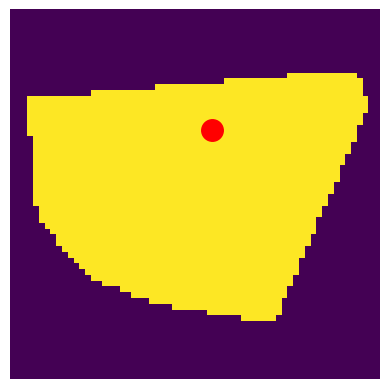

In [ ]:
# | hide

nodes = mesh.interior_nodes()
node = np.random.choice(nodes)
coords = torch.from_numpy((mesh.p.T[node] + 1) / 2).float()

plt.axis('off')
fig = plt.imshow(mask.permute(1, 2, 0))
fig = plt.scatter(
    x=(coords[0] * mask.shape[-1]),
    y=(coords[1] * mask.shape[-1]),
    c='r',
    s=240,
)

:::: {.column text-align="center"}
:::

In [ ]:
materials_rho = [Material(rho, 2.9e+10, 0.25, 5.5, 1.15e-6) for rho in np.linspace(500, 15000, 10)]
materials_nu = [Material(7750, 2.9e+10, nu, 5.5, 1.15e-6) for nu in np.linspace(0.1, 0.49, 10)]
materials_list = [materials_rho, materials_nu]


In [ ]:

sr = 32000
time_in_seconds = 0.2
impulse = torch.zeros(int(time_in_seconds * sr))
impulse[0] = 1.0
k=32
material_interp_dir = Path("assets/results/audio/material_interp")
material_interp_dir.mkdir(exist_ok=True, parents=True)

from neuralresonator.dsp import apply_filter
with torch.no_grad():
    
    features = model.encoder(mask[None, ...].repeat(1, 3, 1, 1).float())

    for mat_list in materials_list:
        for material in mat_list:

            # create a system
            system = System(
                material=material,
                mesh=mesh,
                k=k,
                force_cache=True
            )

            gt_audio = system.render(time_in_seconds, sr, impulse_node_idx=node)

            material_params = torch.tensor([*(material.scaled())]).float()

            # Predict biquad coefficients
            ba = model.forward(torch.cat([features, coords[None, ...], material_params[None, ...]], dim=-1))
            b = ba[..., :3]
            a = ba[..., 3:]

            pred_signal = apply_filter(
                impulse.cpu().numpy(),
                b=b[0].cpu().numpy(),
                a=a[0].cpu().numpy(),
            )
            
            sf.write(f"assets/results/audio/material_interp/gt_{material}.wav", gt_audio, sr)
            sf.write(f"assets/results/audio/material_interp/pred_{material}.wav", pred_signal, sr)

In [ ]:
# open the audio files
print(qmd.tbl_row(['Density', 'Original', 'Predicted' ]))
print(qmd.tbl_sep([2,2,2]))
for material in materials_rho:
    print(
        qmd.tbl_row(
            [f"$\\rho={material.rho:.2f}$"] +
            [audio(f"assets/results/audio/material_interp/gt_{material}.wav", 100)] + 
            [audio(f"assets/results/audio/material_interp/pred_{material}.wav", 100)]
        )
    )

|Density|Original|Predicted|
|--|--|--|
|$\rho=500.00$|![](assets/results/audio/material_interp/gt_Material(rho=500.0, E=29000000000.0, nu=0.25, alpha=5.5, beta=1.15e-06).wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|![](assets/results/audio/material_interp/pred_Material(rho=500.0, E=29000000000.0, nu=0.25, alpha=5.5, beta=1.15e-06).wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|
|$\rho=2111.11$|![](assets/results/audio/material_interp/gt_Material(rho=2111.1111111111113, E=29000000000.0, nu=0.25, alpha=5.5, beta=1.15e-06).wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|![](assets/results/audio/material_interp/pred_Material(rho=2111.1111111111113, E=29000000000.0, nu=0.25, alpha=5.5, beta=1.15e-06).wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|
|$\rho=3722.22$|![](assets/results/audio/material_interp/gt_Material(rho=3722.222222222222, E=29000000000.0, nu=0.25, alpha=5.5, 

In [ ]:
print(qmd.tbl_row(["Poisson's ratio", 'Original', 'Predicted' ]))
print(qmd.tbl_sep([2,2,2]))
for material in materials_nu:
    print(
        qmd.tbl_row(
            [f"$\\nu={material.nu:.2f}$"] +
            [audio(f"assets/results/audio/material_interp/gt_{material}.wav", 100)] + 
            [audio(f"assets/results/audio/material_interp/pred_{material}.wav", 100)]
        )
    )

|Poisson's ratio|Original|Predicted|
|--|--|--|
|$\nu=0.10$|![](assets/results/audio/material_interp/gt_Material(rho=7750, E=29000000000.0, nu=0.1, alpha=5.5, beta=1.15e-06).wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|![](assets/results/audio/material_interp/pred_Material(rho=7750, E=29000000000.0, nu=0.1, alpha=5.5, beta=1.15e-06).wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|
|$\nu=0.14$|![](assets/results/audio/material_interp/gt_Material(rho=7750, E=29000000000.0, nu=0.14333333333333334, alpha=5.5, beta=1.15e-06).wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|![](assets/results/audio/material_interp/pred_Material(rho=7750, E=29000000000.0, nu=0.14333333333333334, alpha=5.5, beta=1.15e-06).wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|
|$\nu=0.19$|![](assets/results/audio/material_interp/gt_Material(rho=7750, E=29000000000.0, nu=0.18666666666666668, alpha=5.5, bet

### Interpolate between two shapes, and see how the audio changes.
> In this case, we do not have discretized positions for the coordinates in the shapes (as FEM requires discretization). Because our network acts as a neural field we can obtain sound for continuous coordinate values. We can interpolate between the two shapes and see how the audio changes.

In [ ]:
# | hide

import scipy.optimize
mesh0, points0 = generate_convex_mesh(n_points=5)
mesh1, points1 = generate_convex_mesh(n_points=5)

In [ ]:
# prepare a cost matrix with the distance between each point for each shape
cost_matrix = scipy.spatial.distance.cdist(points0, points1)

# find the optimal mapping between the two shapes
row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_matrix)

# interpolate 10 shapes between the two shapes
n_shapes = 10
rasterized_shapes = []
for i in range(n_shapes):
    alpha = i / n_shapes
    points = (1 - alpha) * points0[row_ind] + alpha * points1[col_ind]
    rasterized_shapes += [polygon2mask(resolution, ((points + 1) / 2) * resolution[0]).T[None, ...]]
    
# fix a coordinate in the shape
coords = torch.tensor([0.6, 0.5]).float()

# plot the interpolated shapes
fig, axs = plt.subplots(1, 1)

interpolation_path = Path("assets/results/interpolation")
interpolation_path.mkdir(exist_ok=True, parents=True)
for i in range(n_shapes):
    axs.imshow(rasterized_shapes[i].squeeze())
    axs.scatter(
        x=(coords[0] * mask.shape[-1]),
        y=(coords[1] * mask.shape[-1]),
        c='r',
        s=240,
    )
    axs.axis('off')
    plt.tight_layout()
    plt.savefig(interpolation_path / f"interpolation_{i}.png", bbox_inches='tight', pad_inches = 0)

plt.close(fig)

In [ ]:
# Generate sound for each shape

sr = 32000
time_in_seconds = 0.2
impulse = torch.zeros(int(time_in_seconds * 32000))
impulse[0] = 1.0

with torch.no_grad():
        for idx, mask in enumerate(rasterized_shapes):

            # convert to tensor
            mask = torch.from_numpy(mask)
            features = model.encoder(mask[None, ...].repeat(1, 3, 1, 1).float())

            # Predict biquad coefficients
            ba = model.forward(torch.cat([features, coords[None, ...], material_params[None, ...]], dim=-1))
            b = ba[..., :3]
            a = ba[..., 3:]

            pred_signal = apply_filter(
                impulse.cpu().numpy(),
                b=b[0].cpu().numpy(),
                a=a[0].cpu().numpy(),
            )

            sf.write(interpolation_path / f"morph_{idx}.wav", pred_signal, sr)

In [ ]:
print(qmd.tbl_row(['Shape','Predicted sound']))
print(qmd.tbl_sep([2,2]))
for idx, occupancy_map in enumerate(rasterized_shapes):

    print(
        qmd.tbl_row(
            [im(interpolation_path / f"interpolation_{idx}.png", 50)] + 
            [audio(interpolation_path / f"morph_{idx}.wav", 100)]))

|Shape|Predicted sound|
|--|--|
|![](assets/results/interpolation/interpolation_0.png){width="50%"}|![](assets/results/interpolation/morph_0.wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|
|![](assets/results/interpolation/interpolation_1.png){width="50%"}|![](assets/results/interpolation/morph_1.wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|
|![](assets/results/interpolation/interpolation_2.png){width="50%"}|![](assets/results/interpolation/morph_2.wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|
|![](assets/results/interpolation/interpolation_3.png){width="50%"}|![](assets/results/interpolation/morph_3.wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|
|![](assets/results/interpolation/interpolation_4.png){width="50%"}|![](assets/results/interpolation/morph_4.wav){.audio-container style="width: 100px; height: 50px; max-width: 100px"}|
|![](assets/results/interpolation/inte